## Setup

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import librun
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()
from importlib import reload; import libplot; 
from sklearn import metrics
from tabulate import tabulate
import ipywidgets as widgets
from libplot import align_yaxis
import random
from matplotlib.colors import ListedColormap
import libregionplot

import warnings
warnings.filterwarnings("ignore")

In [61]:
from libdatasets import *; from libadversarial import uncertainty_stop
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("rcv1-58509", wrap(rcv1, 58509)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "random-forest"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner, matrix, state: state.X_unlabelled.shape[0] < 510),
        "pool_subsample": 1000
    }
}
datasets = [d[0] for d in matrix['datasets']]
#results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=29)
#results_plots = [result[0] for result in results]
#classifiers = [result[1] for result in results]
#classifiers = [clf for clf in classifiers]

In [62]:
def read_stopping(name):
    file = f"{out_dir()}/stopping2/{name}__none__uncertainty__random-forest__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [67]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

In [68]:
for _name, _conds in results.items():
    for _cname, _runs in _conds.items():
        if isinstance(_runs, dict):
            arr = [None]*(max(_runs.keys())+1)
            for i, v in _runs.items():
                arr[i] = v
            results[_name][_cname] = arr

In [69]:
for _name, _conds in results.items():
    print(_name, len(_conds), len(_conds['Performance Convergence']))
del _name, _conds

webkb 12 30
spamassassin 12 30
avila 12 30
smartphone 12 30
swarm 12 30
sensorless 12 1
splice 12 30
anuran 12 30


In [41]:
criteria = set.union(*[set(list(result.keys())) for result in results.values()])
print(f"Stopping Criteria ({len(criteria)}): {criteria}")

Stopping Criteria (12): {'Uncertainty Convergence', 'VM', 'Stabilizing Predictions', 'Overall Uncertainty', 'SC_oracle_acc', 'Max Confidence', 'SSNCut', 'Contradictory Information', 'EVM', 'SC_entropy_mcs', 'Classification Change', 'Performance Convergence'}


In [49]:
to_plot_min = ['Overall Uncertainty', 'Performance Convergence', 'Max Confidence', 'VM', 'SC_entropy_mcs', 'SC_oracle_acc', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'Classification Change', 'Contradictory Information']
results_filter_min = {dataset: {name: r for name, r in conds.items() if name in to_plot_min} for dataset, conds in results.items()}

### Colormap

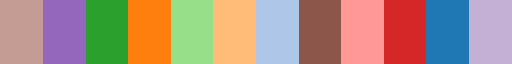

In [28]:
# Seaborn colors
# try husl, hls, gnist_ncar
colors = sns.color_palette('tab20', len(to_plot_min)).as_hex()
random.seed(10); random.shuffle(colors)
criteria_map = {name: color for name, color in zip(to_plot_min, colors)}
cmap = ListedColormap(colors, name='Z'); cmap

## Full Range Pareto Plots

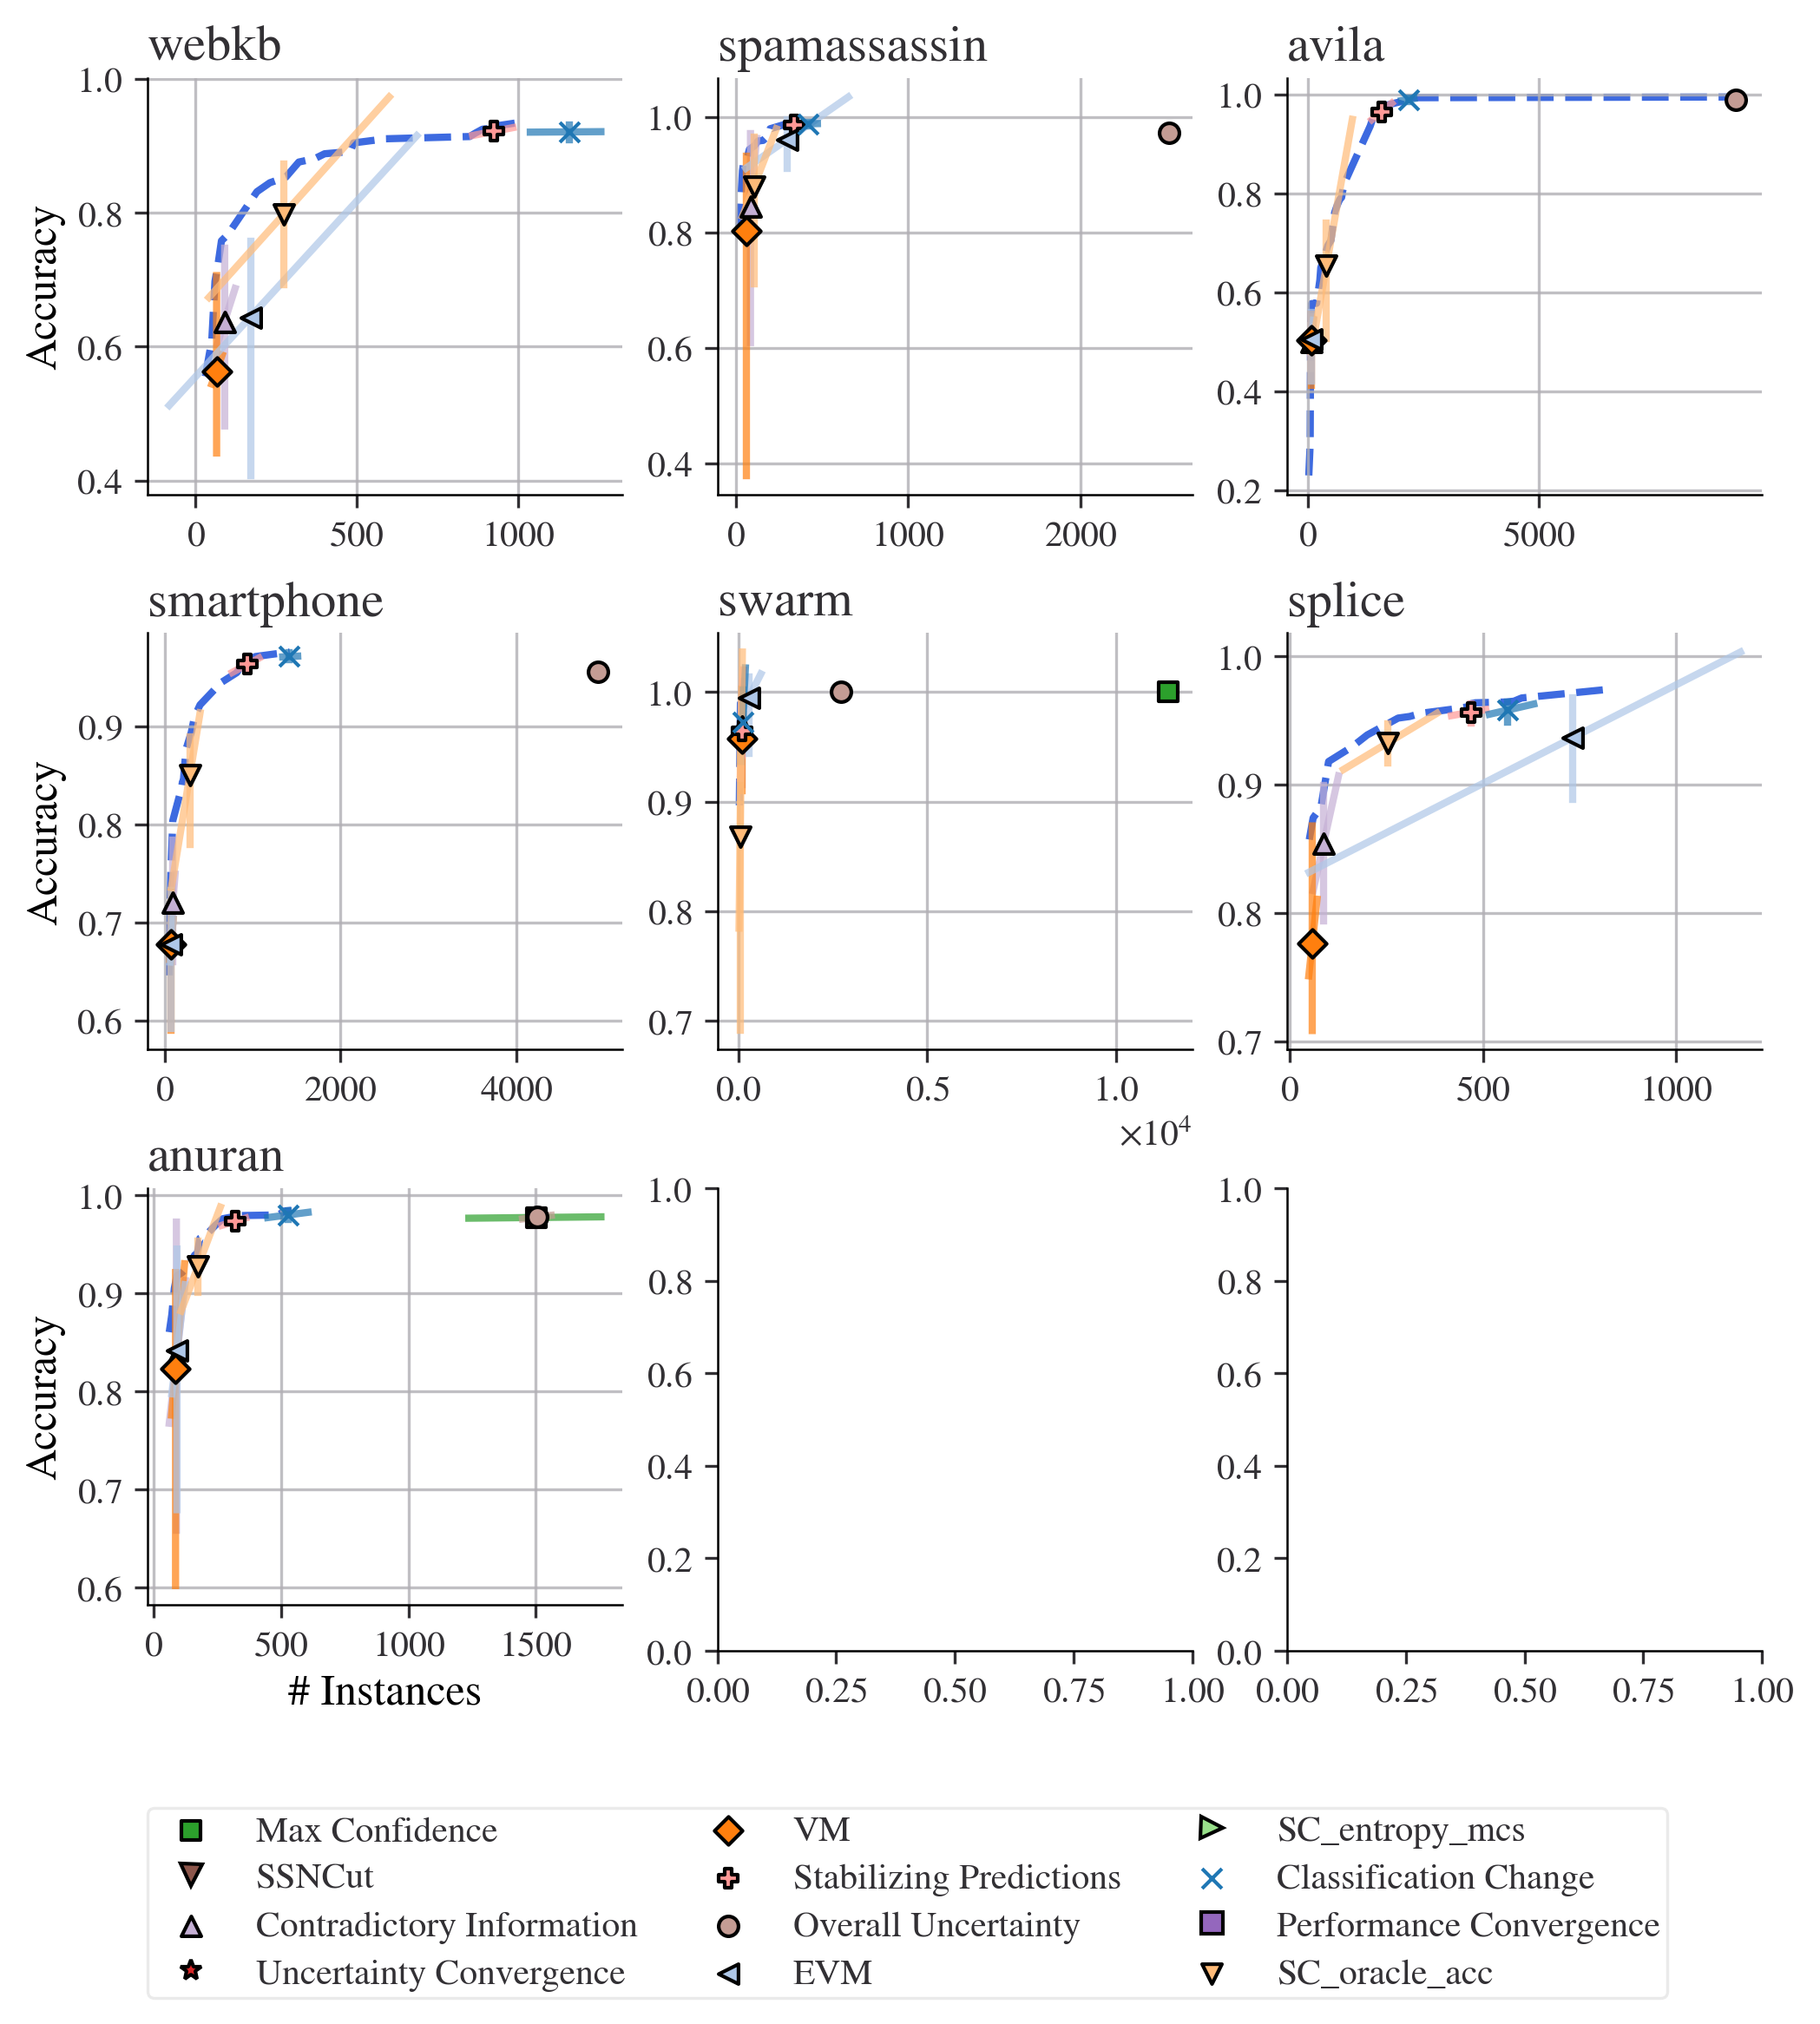

In [50]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter_min, rows=3, cols=3, figsize=(8,8), dpi=300, hull=False, error='pca', colors=criteria_map, legend_loc='upper center', legend_cols=3, legend_bbox=(-0.8, -0.3))

Errors drawn asymmetrically using 2.5% and 97.5% percentiles.

### Optimal Regions (Ranking Formula)

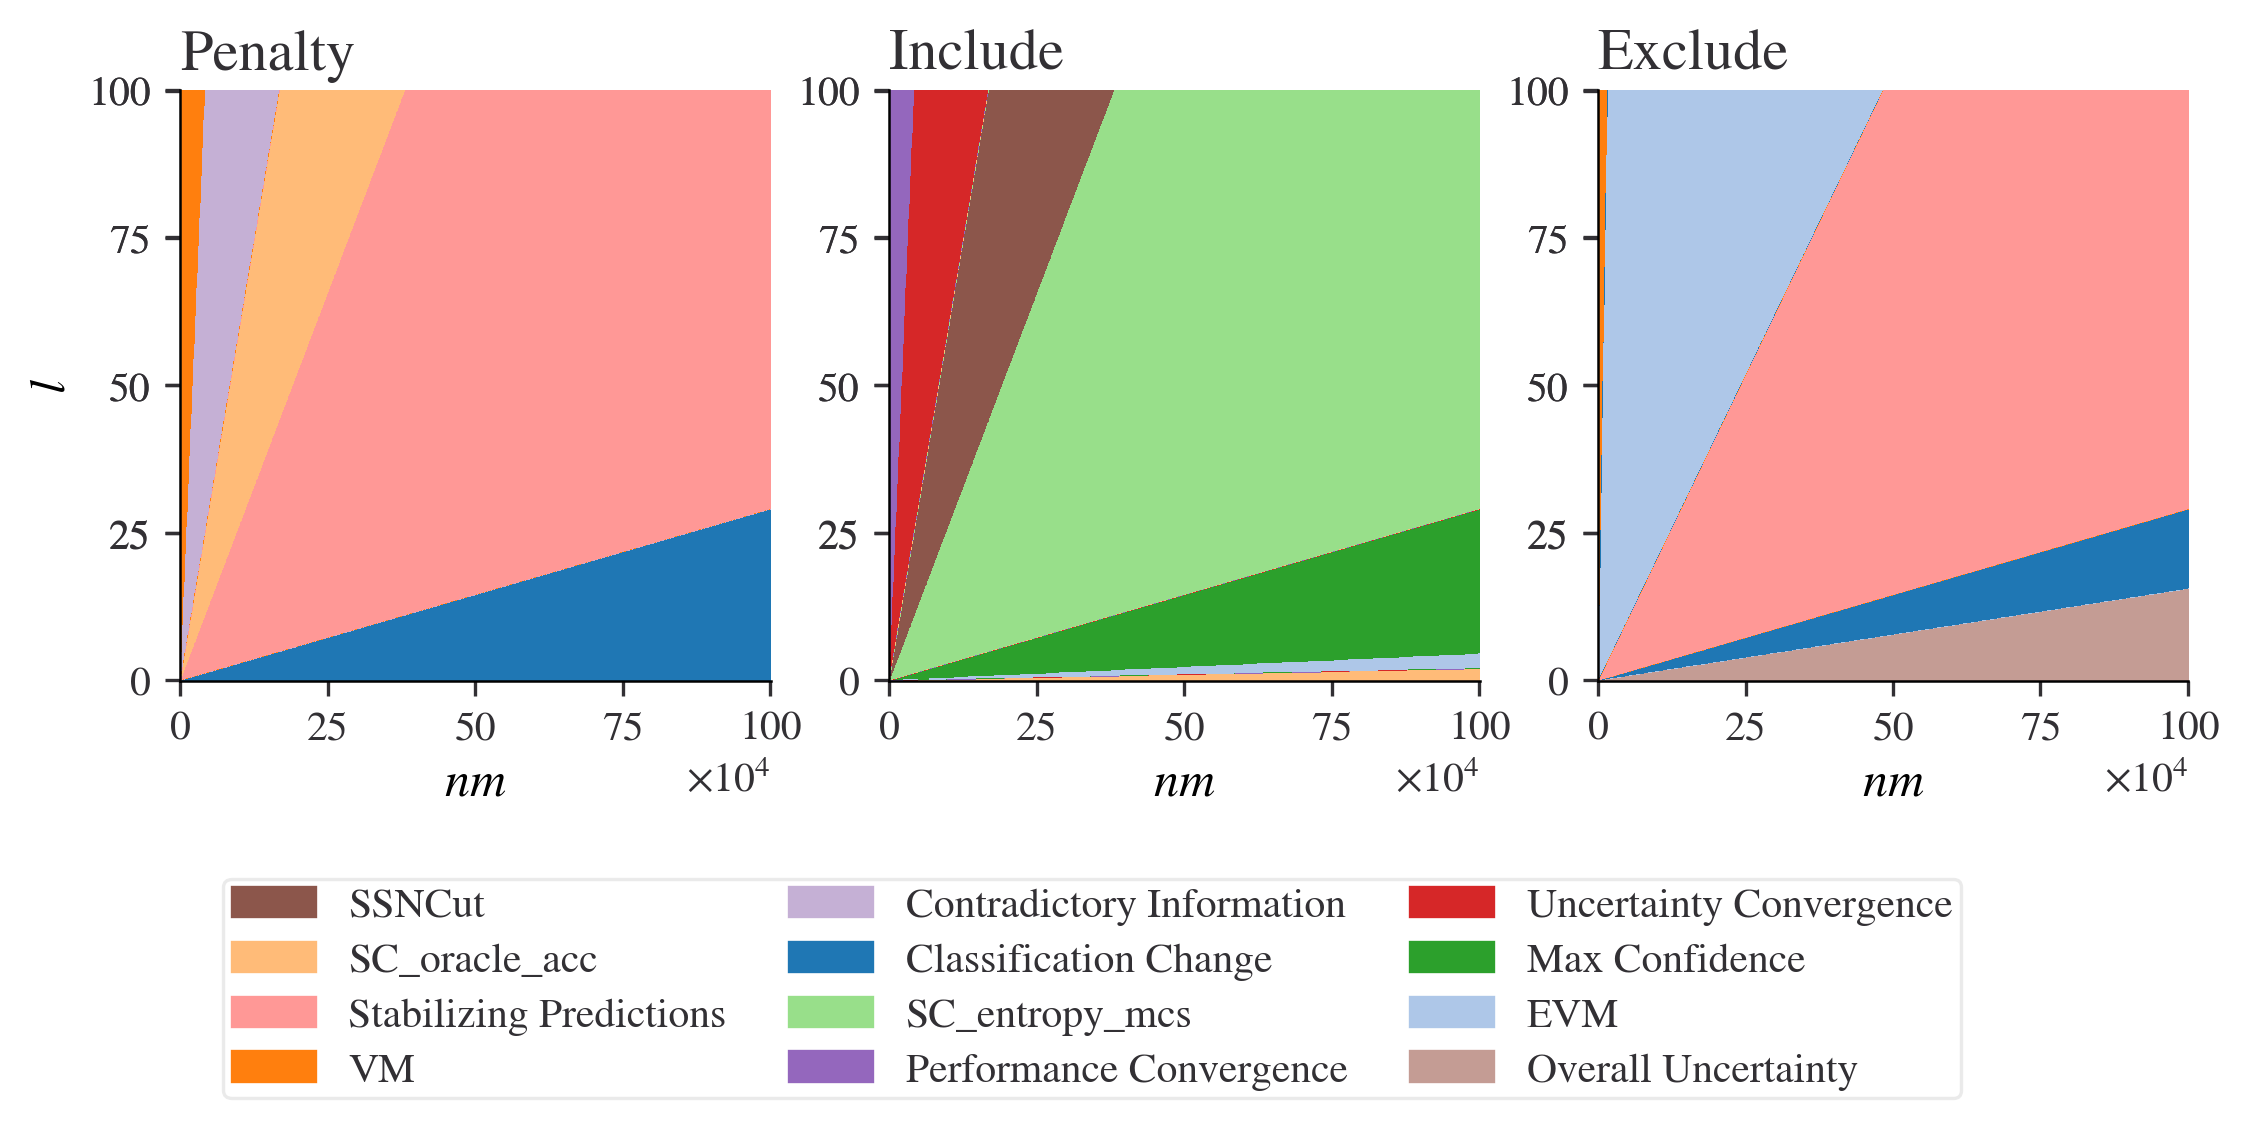

In [53]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=300)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter_min, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.65, -0.3), ncol=3)
#plt.tight_layout()

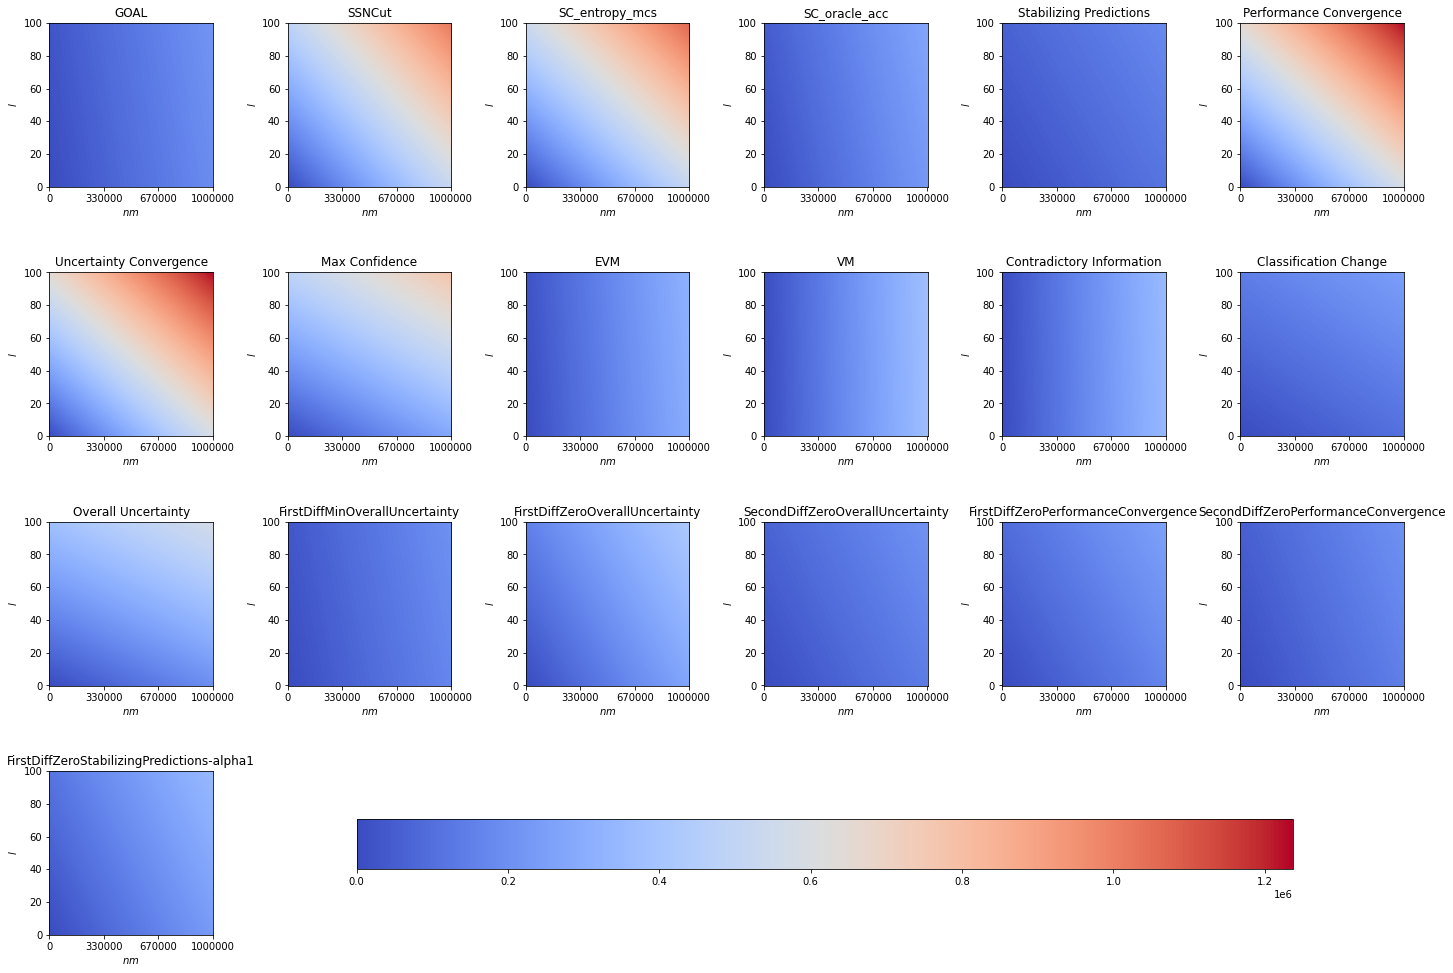

In [846]:
costs(results_filter)

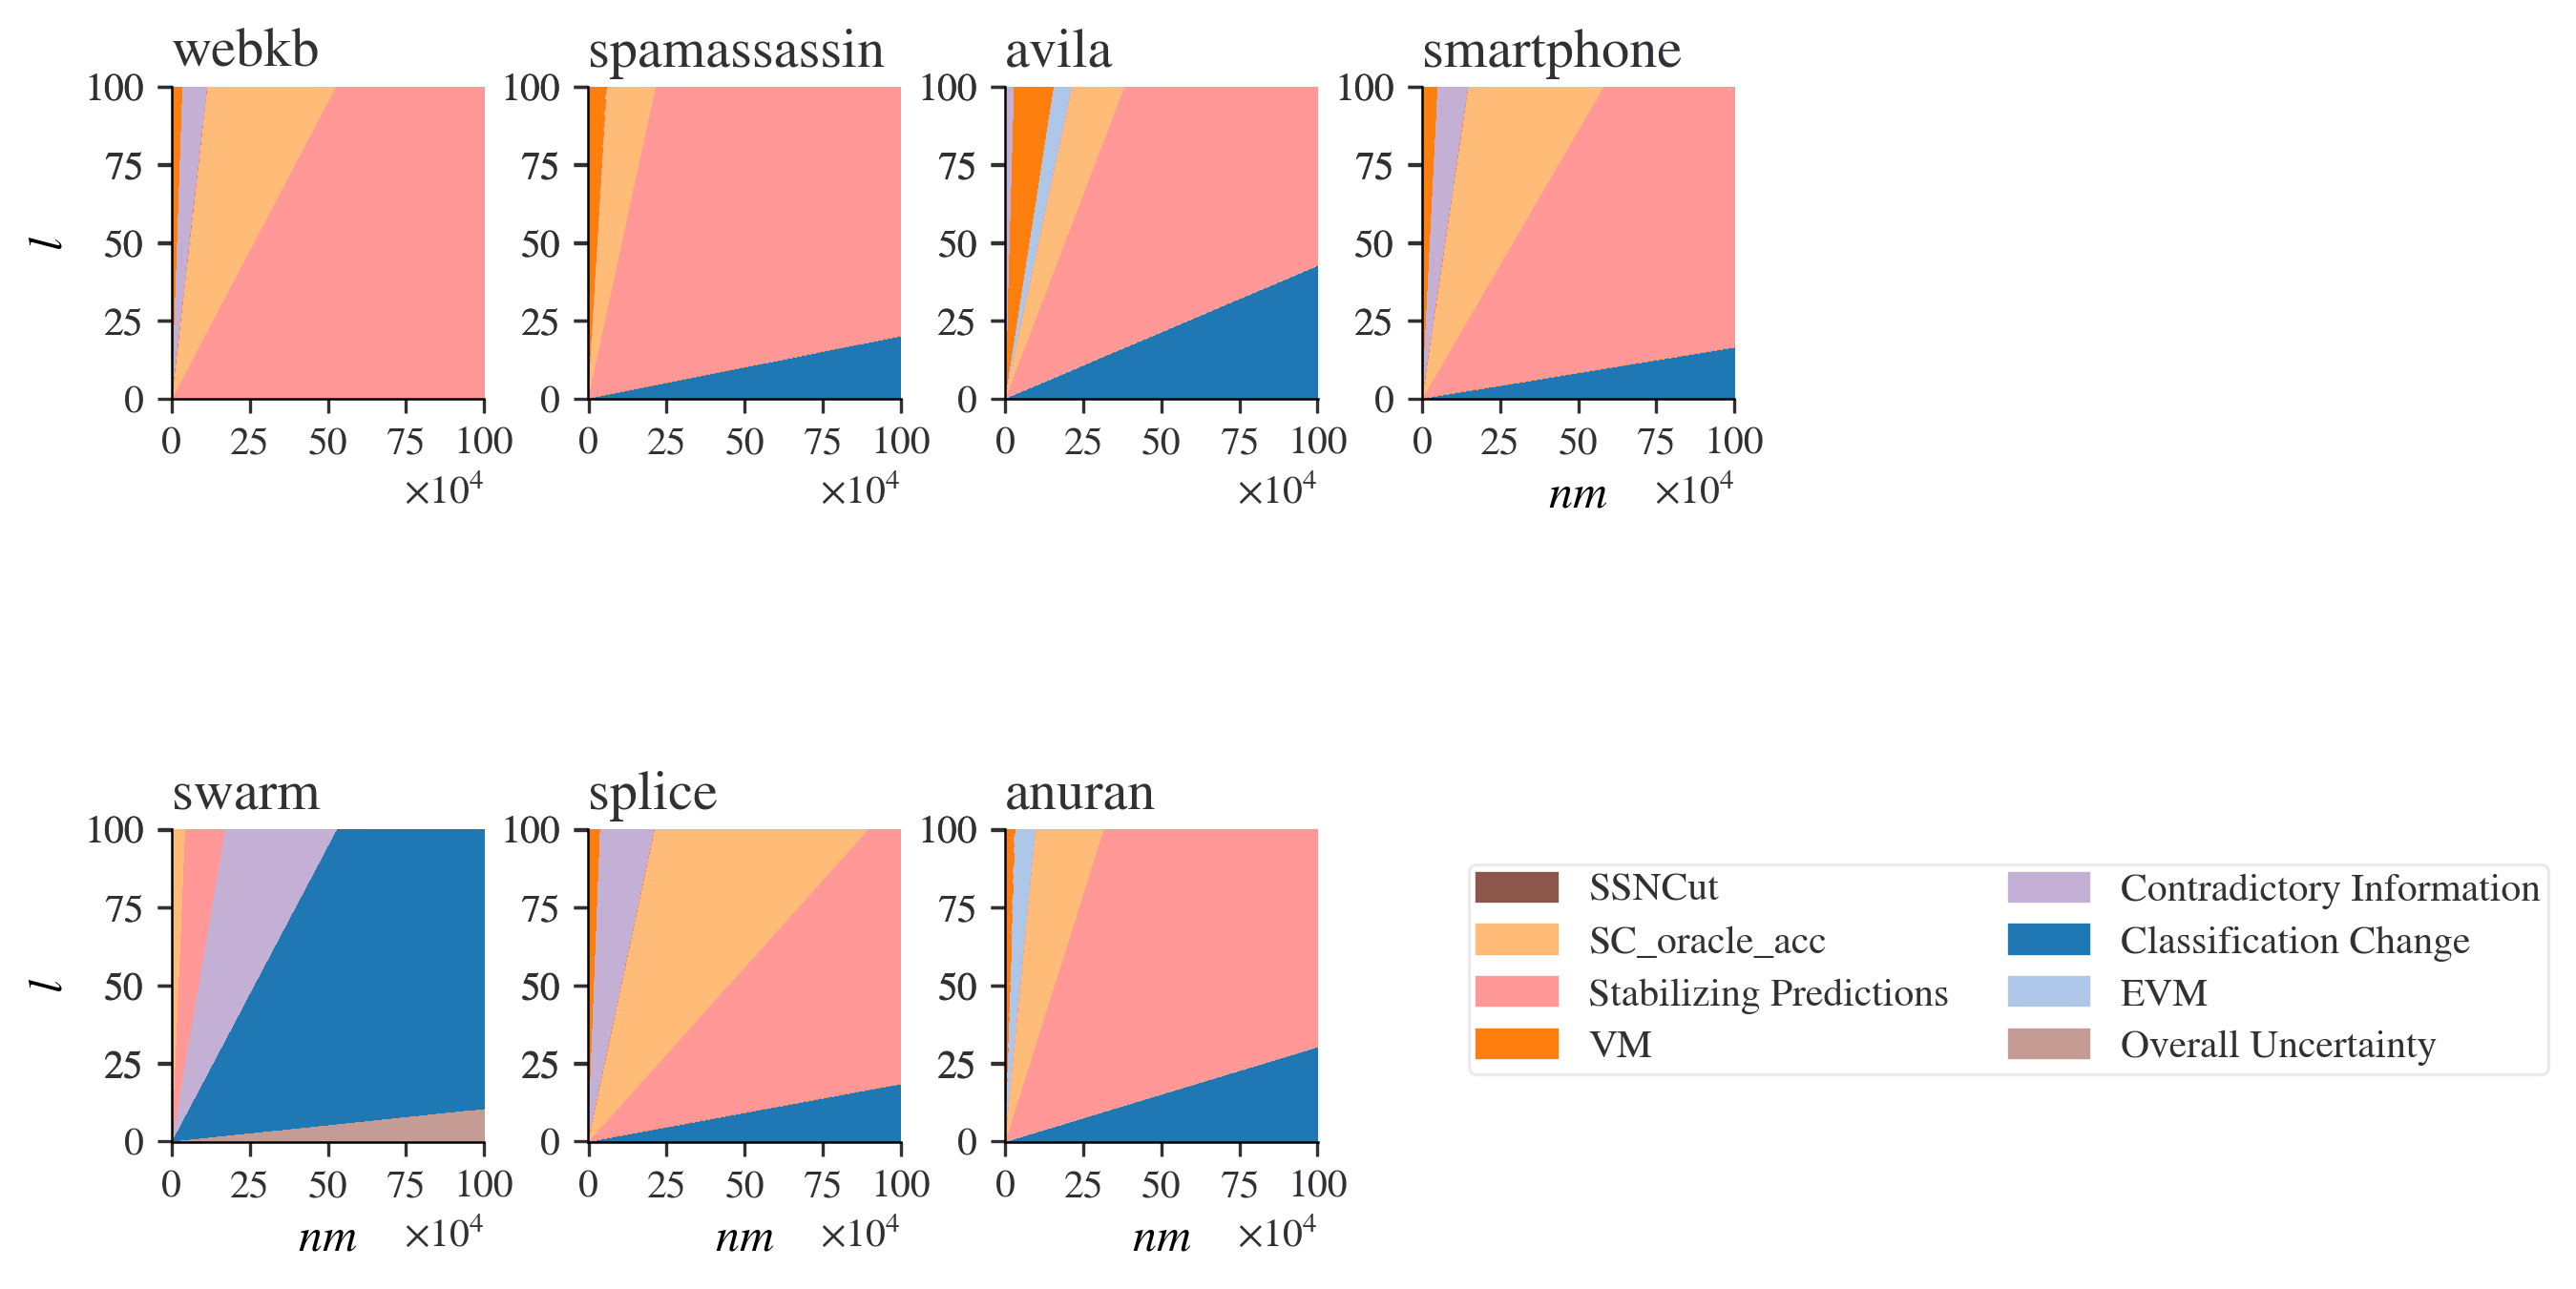

In [54]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
import math
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter_min)/4), 4, figsize=(7.2,6.3), dpi=300)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter_min.items(), axes.flatten())):
        regions(
            {dataset: r}, 
            colors=criteria_map, 
            failed_to_stop="penalty", 
            title=dataset.rstrip("-58509"), 
            ax=ax, 
            patches=patches, 
            left=i%4==0, 
            bottom=i>len(results_filter_min)-5)
    for ax in axes.flatten()[len(results_filter_min):]:
        fig.delaxes(ax)
    for ax in axes.flatten():
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
    plt.legend(handles=patches, bbox_to_anchor=(5., 0.95), ncol=2)
    #plt.suptitle("Linear SVM (Penalty)")

In [56]:
import libregionplot; reload(libregionplot); from libregionplot import *
interactive_explore_cost(results_filter_min, title="Marketing Example")

interactive(children=(IntText(value=87600, description='Expected number of misclassifications n:'), FloatText(…

## Failed To Stop

In [57]:
table = []
for dataset, methods in results_filter_min.items():
    table.append([])
    for method, results in methods.items():
        table[-1].append(f"{np.count_nonzero([result[0] for result in results])}/{len(results)}")

In [58]:
tabulate(table, tablefmt='html', showindex=[s.rstrip("-58509") for s in results_filter_min.keys()], headers=results_filter_min['webkb'].keys())

,SSNCut,SC_entropy_mcs,SC_oracle_acc,Stabilizing Predictions,Performance Convergence,Uncertainty Convergence,Max Confidence,EVM,VM,Contradictory Information,Classification Change,Overall Uncertainty
webkb,0/30,0/30,30/30,30/30,0/30,0/30,0/30,30/30,30/30,30/30,30/30,0/30
spamassassin,0/30,0/30,30/30,30/30,0/30,0/30,0/30,29/30,30/30,30/30,30/30,5/30
avila,0/30,0/30,30/30,30/30,0/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30
smartphone,0/30,0/30,30/30,30/30,0/30,0/30,0/30,30/30,30/30,30/30,30/30,11/30
swarm,0/30,0/30,30/30,30/30,0/30,0/30,30/30,24/30,30/30,30/30,30/30,30/30
splice,0/30,0/30,30/30,30/30,0/30,0/30,0/30,17/30,30/30,30/30,30/30,0/30
anuran,0/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30


In [1337]:
import pandas as pd

In [1354]:
pd.DataFrame(table, [s.rstrip("-58509") for s in results_filter_min.keys()], list(results_filter_min['webkb'].keys())).to_csv('failed_to_stop.csv')

## Raw Results

In [60]:
table = []
for dataset, methods in results_filter_min.items():
    for method, results in methods.items():
        r = np.array(results)
        r = r[r[:,0]!=None]
        if len(r) == 0:
            table.append([dataset, method, *[None]*3])
            continue
        
        mean = np.mean(r, axis=0)
        # 2.5% percentile to 97.5%
        lower = np.percentile(r, 2.5, axis=0)
        upper = np.percentile(r, 97.5, axis=0)
        
        data = []
        for i in range(4):
            #data.append(f"{upper[i]:.2f}|{mean[i]:.2f}|{lower[i]:.2f}")
            data.append(upper[i])
            data.append(mean[i])
            data.append(lower[i])
    
        table.append(
            [dataset, method, *data]
        )

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [94]:
tabulate(
    table,
    tablefmt='html',
    headers=['Dataset', 'Method', 'Instances (Upper)', "Instances (Mean)", 'Instances (Lower)', 'Accuracy (Upper)', 'Accuracy (Mean)', 'Accuracy (Lower)', 'F1 (Upper)', 'F1 (Mean)', 'F1 (Lower)', 'ROC (Upper)', 'ROC (Mean)', 'ROC (Lower)'],
    floatfmt=('', '', *['g']*3, *['.2%']*6)
)

Dataset,Method,Instances (Upper),Instances (Mean),Instances (Lower),Accuracy (Upper),Accuracy (Mean),Accuracy (Lower),F1 (Upper),F1 (Mean),F1 (Lower),ROC (Upper),ROC (Mean),ROC (Lower)
webkb,GOAL,434.25,278,131.25,87.83%,74.46%,57.02%,87.83%,74.46%,57.02%,0.965526,0.913381,0.828042
webkb,SSNCut,,,,,,,,,,,,
webkb,SC_entropy_mcs,,,,,,,,,,,,
webkb,SC_oracle_acc,646,296,44.5,89.11%,71.23%,36.26%,89.11%,71.23%,36.26%,0.97251,0.886621,0.736938
webkb,Stabilizing Predictions,745.25,615,544.5,90.87%,89.00%,87.48%,90.87%,89.00%,87.48%,0.973699,0.965195,0.941108
webkb,Performance Convergence,,,,,,,,,,,,
webkb,Uncertainty Convergence,,,,,,,,,,,,
webkb,Max Confidence,1540,750,10,89.70%,66.25%,30.05%,89.70%,66.25%,30.05%,0.977654,0.717228,0.28901
webkb,EVM,616.5,200,50,88.78%,58.46%,34.19%,88.78%,58.46%,34.19%,0.956576,0.841857,0.750883
webkb,VM,70,56,50,58.47%,44.35%,32.46%,58.47%,44.35%,32.46%,0.844025,0.778234,0.71372
